In [ ]:
import random
import numpy as np
import torch
import torch.nn as nn


# Load  PCA data
data = np.load('/../data/tasic-pca50.npy')
labels = np.load("/../data/tasic-ttypes.npy")
colors = np.load("/../data/tasic-colors.npy")

data_tensor = torch.tensor(data, dtype=torch.float32)
print("Shape of PCA data:", data_tensor.shape)

print("Shape of labels:", len(labels))
print("Unique labels:", np.unique(labels))
print("Number unique labels:", len(np.unique(labels)))
print("Colors shape:", colors.shape)

Shape of PCA data: torch.Size([23822, 50])
Shape of labels: 23822
Unique labels: ['Astro Aqp4' 'CR Lhx5' 'Endo Ctla2a' 'Endo Cytl1'
 'L2/3 IT ALM Macc1 Lrg1' 'L2/3 IT ALM Ptrf' 'L2/3 IT ALM Sla'
 'L2/3 IT VISp Adamts2' 'L2/3 IT VISp Agmat' 'L2/3 IT VISp Rrad'
 'L4 IT VISp Rspo1' 'L5 IT ALM Cbln4 Fezf2' 'L5 IT ALM Cpa6 Gpr88'
 'L5 IT ALM Gkn1 Pcdh19' 'L5 IT ALM Lypd1 Gpr88' 'L5 IT ALM Npw'
 'L5 IT ALM Pld5' 'L5 IT ALM Tmem163 Arhgap25' 'L5 IT ALM Tmem163 Dmrtb1'
 'L5 IT ALM Tnc' 'L5 IT VISp Batf3' 'L5 IT VISp Col27a1'
 'L5 IT VISp Col6a1 Fezf2' 'L5 IT VISp Hsd11b1 Endou'
 'L5 IT VISp Whrn Tox2' 'L5 NP ALM Trhr Nefl' 'L5 NP VISp Trhr Cpne7'
 'L5 NP VISp Trhr Met' 'L5 PT ALM Hpgd' 'L5 PT ALM Npsr1'
 'L5 PT ALM Slco2a1' 'L5 PT VISp C1ql2 Cdh13' 'L5 PT VISp C1ql2 Ptgfr'
 'L5 PT VISp Chrna6' 'L5 PT VISp Krt80' 'L5 PT VISp Lgr5' 'L6 CT ALM Cpa6'
 'L6 CT ALM Nxph2 Sla' 'L6 CT VISp Ctxn3 Brinp3' 'L6 CT VISp Ctxn3 Sla'
 'L6 CT VISp Gpr139' 'L6 CT VISp Krt80 Sla' 'L6 CT VISp Nxph2 Wls'
 'L6 IT AL

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [40]:
# Should be moved to seperate py once repo made
# also remember jax rewrtiting some time

class VAE(nn.Module):
    def __init__(self, input_dim=50, latent_dim=2):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU()
        )
        self.mu = nn.Linear(64, latent_dim)
        self.logvar = nn.Linear(64, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64), nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = self.mu(h), self.logvar(h)
        std = torch.exp(0.5 * logvar)
        z = mu + std * torch.randn_like(std)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar


def loss_fn(x, x_recon, mu, logvar):
    recon_loss = nn.MSELoss()(x_recon, x)
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    return recon_loss + kl


In [65]:
SEED = 12

# Python
random.seed(SEED)

# NumPy
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU

# Make cuDNN deterministic (slower, but reproducible)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


Epoch 400, Loss: 8367.5703


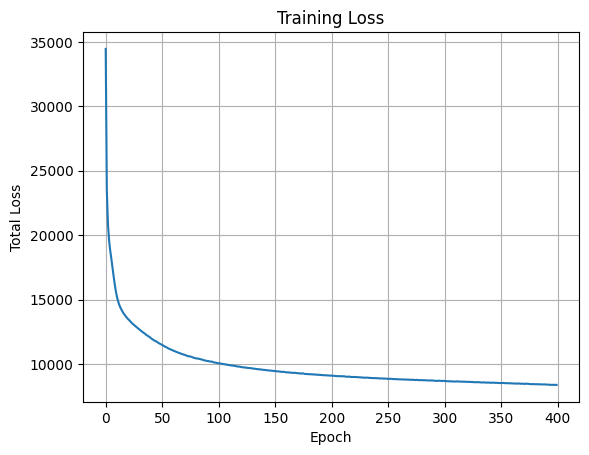

In [66]:
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt

# Move data to device
data_tensor = data_tensor.to(device)

# DataLoader
batch_size = 64
data_loader = DataLoader(data_tensor, batch_size=batch_size, shuffle=True)

# Initialize model
vae = VAE(input_dim=50, latent_dim=2).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)


# Training
num_epochs = 400
losses = []
for epoch in range(num_epochs):
    total_loss = 0
    for batch in data_loader:
        x = batch.to(device)
        x_recon, mu, logvar = vae(x)
        loss = loss_fn(x, x_recon, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    losses.append(total_loss)

print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Total Loss")
plt.title("Training Loss")
plt.grid(True)
plt.show()

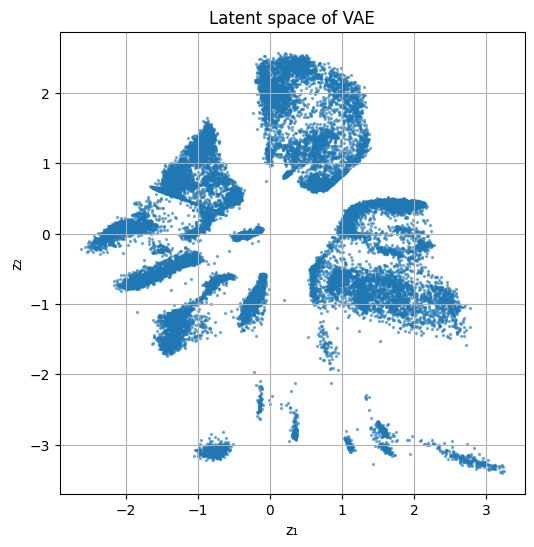

In [67]:
# Extract Latent Representations
# exploring mu for now for all 23k ish cells:
vae.eval()
latents = []
with torch.no_grad():
    for batch in DataLoader(data_tensor, batch_size=256):
        batch = batch.to(device)
        _, mu, _ = vae(batch)
        latents.append(mu.cpu())
latents = torch.cat(latents, dim=0).numpy()

# Plotted the 2D latent space
plt.figure(figsize=(6,6))
plt.scatter(latents[:, 0], latents[:, 1], s=2, alpha=0.5)
plt.title("Latent space of VAE")
plt.xlabel("z₁")
plt.ylabel("z₂")
plt.grid(True)
plt.show()


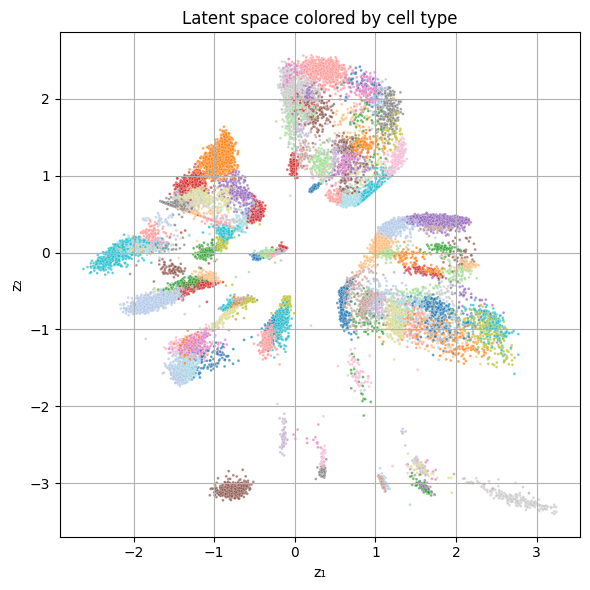

In [68]:
import seaborn as sns

plt.figure(figsize=(6, 6))
ax = sns.scatterplot(
    x=latents[:, 0], y=latents[:, 1],
    hue=labels, s=4, alpha=0.7, palette="tab20", legend=False)
plt.title("Latent space colored by cell type")
plt.xlabel("z₁")
plt.ylabel("z₂")
plt.grid(True)
plt.tight_layout()
plt.show()


In [69]:
# Select 25 Random Latent Point-Pairs
import random
import pickle

# Set random seed for reproducibility
random.seed(42)

# Select 25 fixed data point index pairs
num_pairs = 25
indices = list(range(len(data_tensor)))
pairs_idx = [random.sample(indices, 2) for _ in range(num_pairs)]

# Save to file so you can reuse them across VAE trainings
with open("fixed_data_pairs.pkl", "wb") as f:
    pickle.dump(pairs_idx, f)

print("Saved 25 fixed data index pairs.")


Saved 25 fixed data index pairs.


In [70]:
# load index pairs, encode points and get their latent mu:
# Load fixed index pairs
with open("fixed_data_pairs.pkl", "rb") as f:
    pairs_idx = pickle.load(f)

vae.eval()
mu_latents = []

# Collect latent representations of all data
with torch.no_grad():
    latents = []
    for batch in DataLoader(data_tensor, batch_size=256):
        batch = batch.to(device)
        _, mu, _ = vae(batch)
        latents.append(mu.cpu())
    latents = torch.cat(latents, dim=0)

# Extract latent pairs
latent_pairs = [(latents[i], latents[j]) for i, j in pairs_idx]


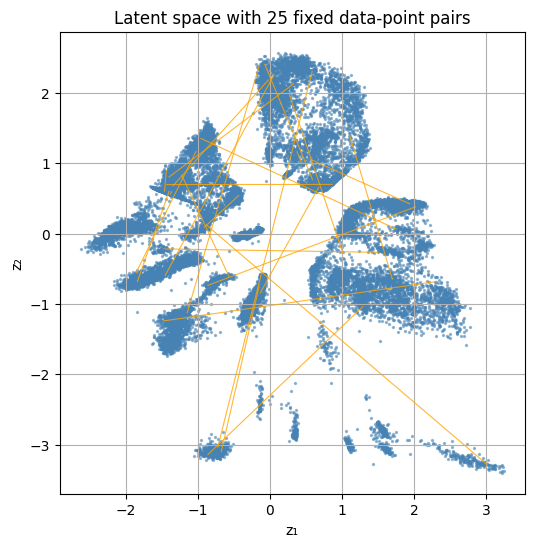

In [71]:
# Turn tensor to numpy if needed
latents_np = latents.numpy() if isinstance(latents, torch.Tensor) else latents

plt.figure(figsize=(6, 6))
plt.scatter(latents_np[:, 0], latents_np[:, 1], s=2, alpha=0.5, color='steelblue')

# Overlay 25 fixed pairs as lines
for z0, z1 in latent_pairs:
    z0_np, z1_np = z0.numpy(), z1.numpy()
    plt.plot([z0_np[0], z1_np[0]], [z0_np[1], z1_np[1]], color='orange', linewidth=0.8, alpha=0.8)

plt.title("Latent space with 25 fixed data-point pairs")
plt.xlabel("z₁")
plt.ylabel("z₂")
plt.grid(True)
plt.show()


Euclideans

In [72]:
# DISCRETIZE latent space (graph)
import numpy as np
from sklearn.neighbors import NearestNeighbors
import networkx as nx

# build a k-NN-index (on latent mu)
k = 250  # number of neighbors per node - more connectivity

# latents should be a numpy array of shape (23822, 2)
nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(latents)
distances, indices = nbrs.kneighbors(latents)

#build graph on netowkrx
G = nx.Graph()

# Add nodes and edges
for i in range(len(latents)):
    for neighbor_idx, dist in zip(indices[i], distances[i]):
        if i != neighbor_idx:  # avoid self-loops
            G.add_edge(i, neighbor_idx, weight=dist)


Now G is a graph over the latent space, where:

Nodes = latent points

Edges = Euclidean connections to k nearest neighbors

Weights = edge distances

In [73]:
print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())

Nodes: 23822
Edges: 3557882


In [74]:

import networkx as nx

print("Is graph connected?", nx.is_connected(G))
print("Number of connected components:", nx.number_connected_components(G))


components = list(nx.connected_components(G))
component_sizes = [len(c) for c in components]

# Sort by size (largest first)
component_sizes.sort(reverse=True)
print("Number of components:", len(component_sizes))
print("Sizes of components:", component_sizes)



Is graph connected? True
Number of connected components: 1
Number of components: 1
Sizes of components: [23822]


In [75]:
largest_component = max(nx.connected_components(G), key=len)
largest_nodes = set(largest_component)

# Filter your pairs
filtered_pairs = [(i, j) for (i, j) in pairs_idx if i in largest_nodes and j in largest_nodes]
print(f"Kept {len(filtered_pairs)} connected pairs out of {len(pairs_idx)}")


Kept 25 connected pairs out of 25


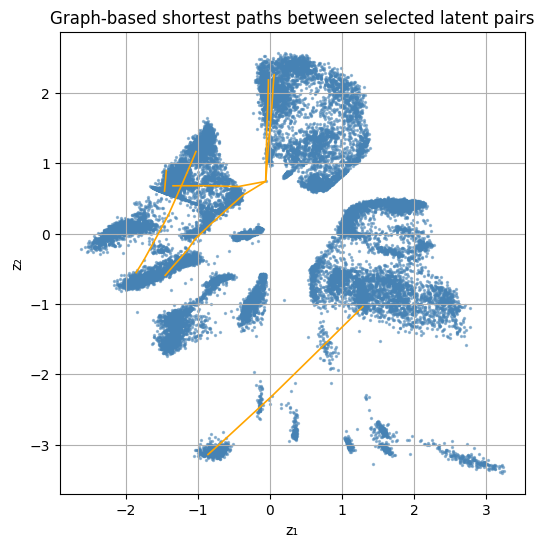

In [76]:
# compute shortest paths for each pair
shortest_paths = []

for i, j in filtered_pairs:
    try:
        path = nx.shortest_path(G, source=i, target=j, weight='weight')
        shortest_paths.append(path)
    except nx.NetworkXNoPath:
        print(f"No path found between {i} and {j}")
        shortest_paths.append([])

#plot a few pairs to chekc on the latent space
plt.figure(figsize=(6, 6))
plt.scatter(latents[:, 0], latents[:, 1], s=2, alpha=0.5, color='steelblue')

for path in shortest_paths[:5]:  # first 5 paths
    coords = latents[np.array(path)]
    plt.plot(coords[:, 0], coords[:, 1], color='orange', linewidth=1.2)

plt.title("Graph-based shortest paths between selected latent pairs")
plt.xlabel("z₁")
plt.ylabel("z₂")
plt.grid(True)
plt.show()



Still euclidean pairs (not all pairs kept).

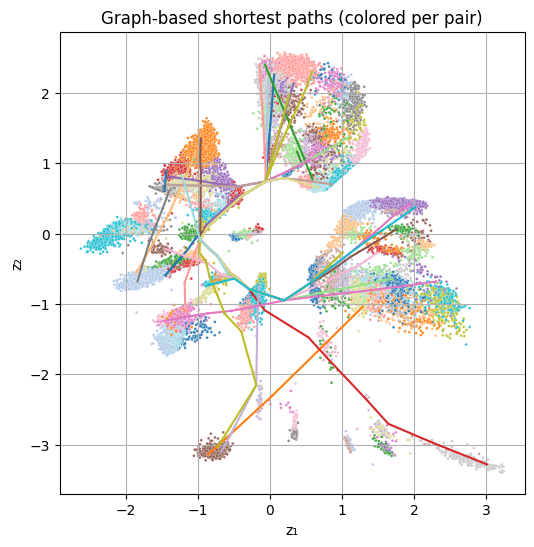

In [77]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Correct way to get a colormap and normalize its range
cmap = plt.colormaps["tab20"]
num_paths = len(shortest_paths)

plt.figure(figsize=(6, 6))
sns.scatterplot(
    x=latents[:, 0], y=latents[:, 1],
    hue=labels, s=4, alpha=0.9, palette="tab20", legend=False
)

# Plot each path with a different color
for idx, path in enumerate(shortest_paths):
    if len(path) == 0:
        continue
    coords = latents[np.array(path)]
    color = cmap(idx / num_paths)  # Use fractional index to spread over colormap
    plt.plot(coords[:, 0], coords[:, 1], color=color, linewidth=1.5)

plt.title("Graph-based shortest paths (colored per pair)")
plt.xlabel("z₁")
plt.ylabel("z₂")
plt.grid(True)
plt.show()
